In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import numpy as np
import pandas as pd
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from scipy.stats import spearmanr
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import os
import math
import random

In [5]:
config_name = 'ml_wang'
eval_task = 'single'
pred_target = 'dep_weekly'

In [6]:
ds_key = 'INS-W_1'
folder = os.path.join('./tmp/cross_validate/', config_name, eval_task, pred_target, ds_key)
# folder = os.path.join('evaluation_output/ml/', config_name, eval_task, pred_target, ds_key)

dirs = os.listdir(folder)
prefices = set([dir[:-7] for dir in dirs])
print(prefices)

{'y_pred_', 'y_targ_', 'demographic_test_'}


In [10]:
from fairlearn.metrics import MetricFrame, false_positive_rate, selection_rate, false_negative_rate, count
from sklearn.metrics import accuracy_score, recall_score

cnt = len(dirs) // len(prefices)
preds = []
targs = []
demos = []
for k in range(cnt):
    path_pred = os.path.join(folder, 'y_pred_{:03d}.npy'.format(k + 1))
    path_targ = os.path.join(folder, 'y_targ_{:03d}.csv'.format(k + 1))
    path_demo = os.path.join(folder, 'demographic_test_{:03d}.csv'.format(k + 1))

    pred = np.load(path_pred, allow_pickle=True)
    targ = pd.read_csv(path_targ)["y_raw"]
    demo = pd.read_csv(path_demo).iloc[:, 1:]

    preds.append(pred)
    targs.append(targ)
    demos.append(demo)

pred = np.concatenate(preds)
targ = pd.concat(targs)
demo = pd.concat(demos)

metrics = {"count": count, "accuracy": accuracy_score, 
    "recall": recall_score, "fnr": false_negative_rate, 
    "fpr": false_positive_rate, "selection": selection_rate}

mfs = {}
for col in demo.columns:
    print(f"column:{col}\n")
    mf = MetricFrame(metrics=metrics, y_true=targ, y_pred=pred, sensitive_features=demo[col])
    print(mf.by_group)
    mfs[col] = (mf)

    

column:gender_DEMO

              count  accuracy    recall       fnr       fpr  selection
gender_DEMO                                                           
1.0          1362.0  0.613069  0.320611  0.679389  0.204057   0.248899
2.0          3094.0  0.547511  0.187924  0.812076  0.125309   0.155139
column:race_DEMO

            count  accuracy    recall       fnr       fpr  selection
race_DEMO                                                           
0.0        2152.0  0.538104  0.275769  0.724231  0.184512   0.231413
1.0        1432.0  0.632682  0.085774  0.914226  0.093291   0.090782
2.0         612.0  0.514706  0.232704  0.767296  0.180272   0.207516
3.0          88.0  0.625000  0.340000  0.660000  0.000000   0.193182
4.0         172.0  0.552326  0.173913  0.826087  0.309524   0.273256
column:orientation_heterosexual_DEMO

                                count  accuracy    recall       fnr       fpr  \
orientation_heterosexual_DEMO                                               

In [11]:
print(mfs.keys())

dict_keys(['gender_DEMO', 'race_DEMO', 'orientation_heterosexual_DEMO', 'student_international_DEMO', 'student_1stGen_DEMO', 'college_engineer_DEMO', 'parent_edu_mother_DEMO', 'parent_edu_father_DEMO', 'generation_DEMO'])


In [13]:
print(type(mfs['gender_DEMO'].by_group))
print(mfs['gender_DEMO'].by_group)

<class 'pandas.core.frame.DataFrame'>
              count  accuracy    recall       fnr       fpr  selection
gender_DEMO                                                           
1.0          1362.0  0.613069  0.320611  0.679389  0.204057   0.248899
2.0          3094.0  0.547511  0.187924  0.812076  0.125309   0.155139


In [14]:
def mkdir(path):
	if not os.path.exists(path):
		os.makedirs(path)

In [16]:
folder_output = os.path.join('./tmp/cross_validate_output/', config_name, eval_task, pred_target, ds_key)
mkdir(os.path.join(folder_output))
for col, mf in mfs.items():
    mf.by_group.to_csv(os.path.join(folder_output, '{}_by_group.csv'.format(col)))
    mf.overall.to_csv(os.path.join(folder_output, '{}_overall.csv'.format(col)))

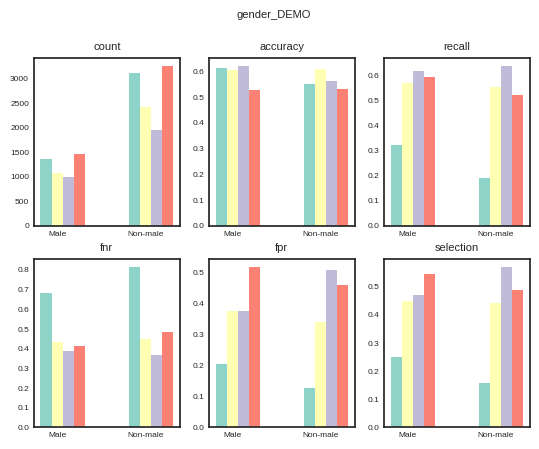

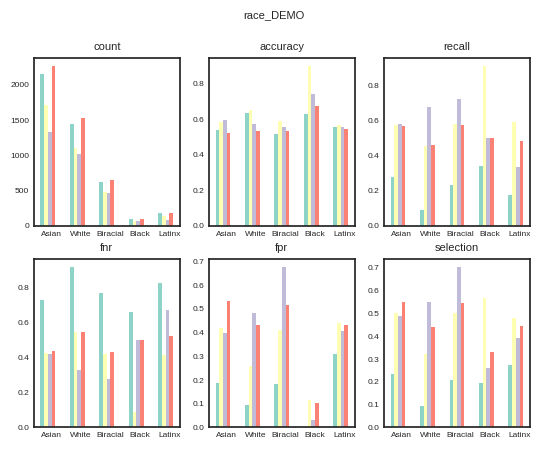

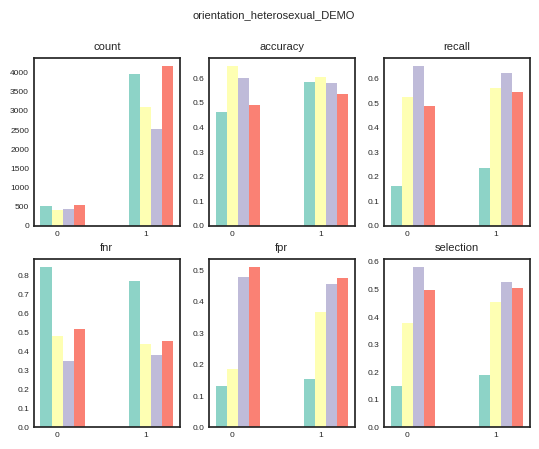

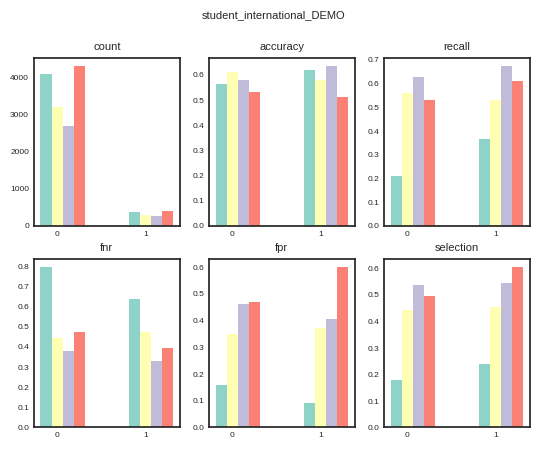

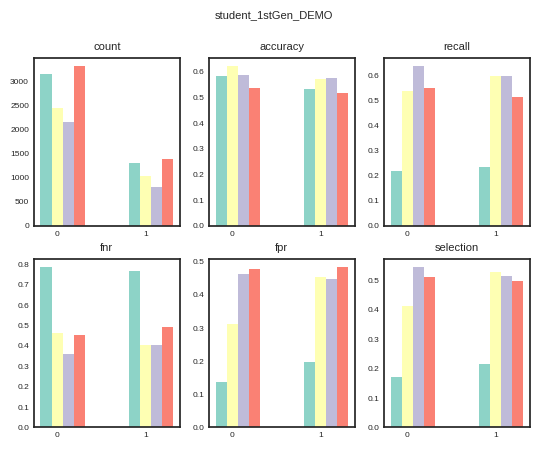

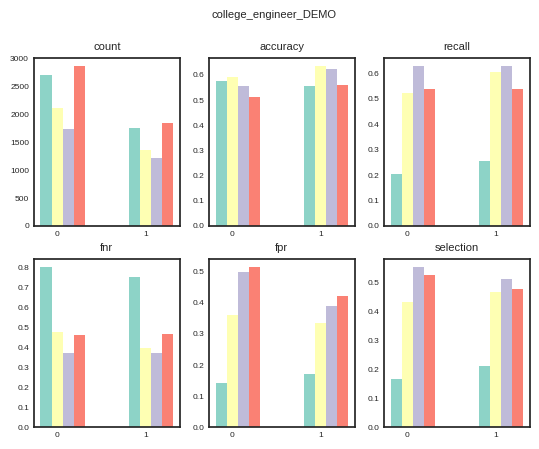

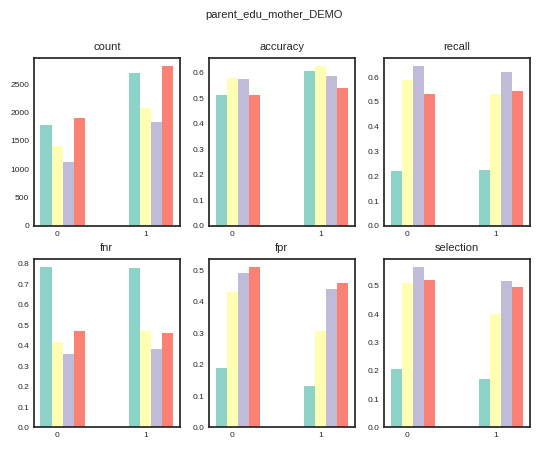

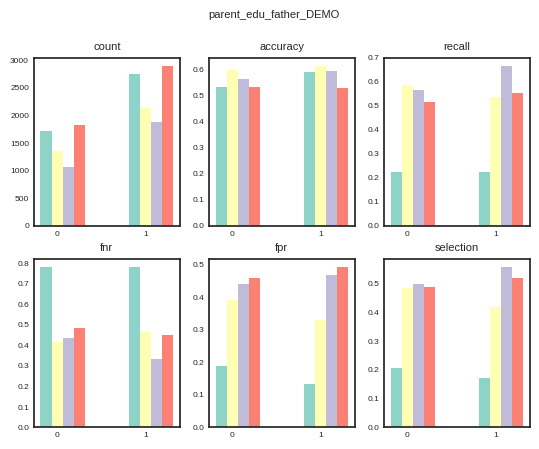

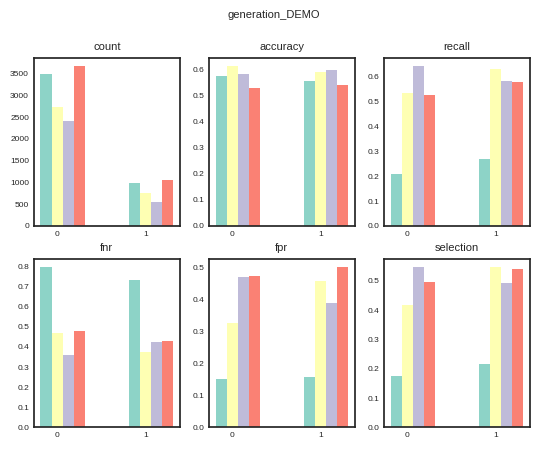

In [102]:
config_names = ['ml_wang', 'ml_xu_interpretable', 'ml_xu_personalized']
eval_task = 'single'
pred_target = 'dep_weekly'
ds_keys = ['INS-W_1', 'INS-W_2', 'INS-W_3', 'INS-W_4']

ds_keys, config_names = ['INS-W_1'], ['ml_wang', 'ml_chikersal', 'ml_xu_interpretable', 'ml_xu_personalized']

for k, ds_key in enumerate(ds_keys):
    n_cfg = len(config_names)
    axes = {}
    for i, config_name in enumerate(config_names):
        folder = os.path.join('./tmp/cross_validate/', config_name, eval_task, pred_target, ds_key)
        dirs = os.listdir(folder)
        prefices = set([dir[:-7] for dir in dirs])
        cnt = len(dirs) // len(prefices)
        preds = []
        targs = []
        demos = []
        for j in range(cnt):
            path_pred = os.path.join(folder, 'y_pred_{:03d}.npy'.format(j + 1))
            path_targ = os.path.join(folder, 'y_targ_{:03d}.csv'.format(j + 1))
            path_demo = os.path.join(folder, 'demographic_test_{:03d}.csv'.format(j + 1))

            pred = np.load(path_pred, allow_pickle=True)
            targ = pd.read_csv(path_targ)["y_raw"]
            demo = pd.read_csv(path_demo).iloc[:, 1:]

            preds.append(pred)
            targs.append(targ)
            demos.append(demo)

        pred = np.concatenate(preds)
        targ = pd.concat(targs)
        demo = pd.concat(demos)

        metrics = {"count": count, "accuracy": accuracy_score, 
            "recall": recall_score, "fnr": false_negative_rate, 
            "fpr": false_positive_rate, "selection": selection_rate}


        mfs = {}
        for l, col in enumerate(demo.columns):
            mf = MetricFrame(metrics=metrics, y_true=targ, y_pred=pred, sensitive_features=demo[col])
            mfs[col] = (mf)

            if not i:
                plt.figure(l)
                plt.suptitle(col)
                axes[col] = {}
                for j, met in enumerate(metrics):
                    axes[col][met] = plt.subplot(2, 3, j + 1)
                    axes[col][met].set_title(met)
                    # plt.figure(l * len(metrics) + j)
                    # axes[col][met] = plt.subplot(1, 1, 1)
                    # axes[col][met].set_title(met)
                    # axes[col][met].set_xlabel(col)
                    axes[col][met].set_xticks(np.arange(len(mf.by_group[met].values)))
                    if col == 'gender_DEMO':
                        axes[col][met].set_xticks(np.arange(len(mf.by_group[met].values)), ['Male', 'Non-male'])
                    if col == 'race_DEMO':
                        axes[col][met].set_xticks(np.arange(len(mf.by_group[met].values)), ["Asian", "White", 'Biracial', 'Black', 'Latinx'])
            for met in metrics:
                y = mf.by_group[met].values
                width = .5 / n_cfg
                x = np.arange(y.shape[0]) - y.shape[0] / 2 * width + i * width
                axes[col][met].bar(x, y, width = width, label = config_name)

        folder_output = os.path.join('./tmp/cross_validate_output/', config_name, eval_task, pred_target, ds_key)
        mkdir(os.path.join(folder_output))
        for col, mf in mfs.items():
            mf.by_group.to_csv(os.path.join(folder_output, '{}_by_group.csv'.format(col)))
            mf.overall.to_csv(os.path.join(folder_output, '{}_overall.csv'.format(col)))
    
    for ijkl in range(len(demo.columns)):
        plt.figure(ijkl)

    plt.show()

In [100]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [101]:
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
import pickle

print(mpl.matplotlib_fname())
print(mpl.get_cachedir())
MEDIUM_SIZE = 8
SMALLER_SIZE = 6
BIGGER_SIZE = 25
# plt.rc('font', family='Helvetica', size=MEDIUM_SIZE)
plt.rc('font', size=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axs[i, 0]es title
plt.rc('xtick', labelsize=SMALLER_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALLER_SIZE)  # fontsize of the tick labels
plt.rc('figure', titlesize=MEDIUM_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.style.use('dark_background')
plt.style.use('seaborn-white')
FIG_HEIGHT = 2
FIG_WIDTH = 2

/homes/gws/ylsheng/miniconda3/envs/globem/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc
/homes/gws/ylsheng/.cache/matplotlib


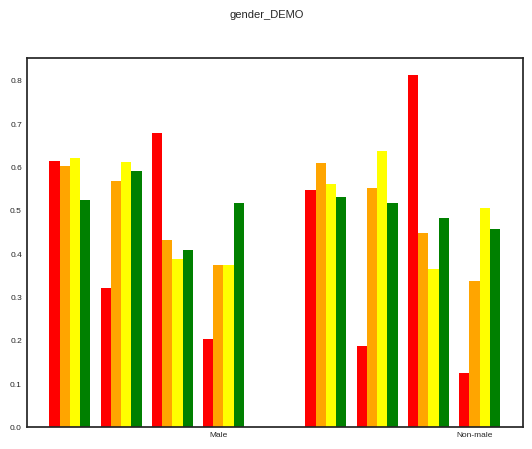

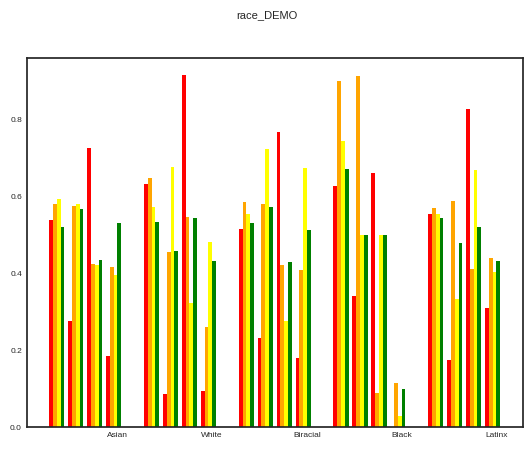

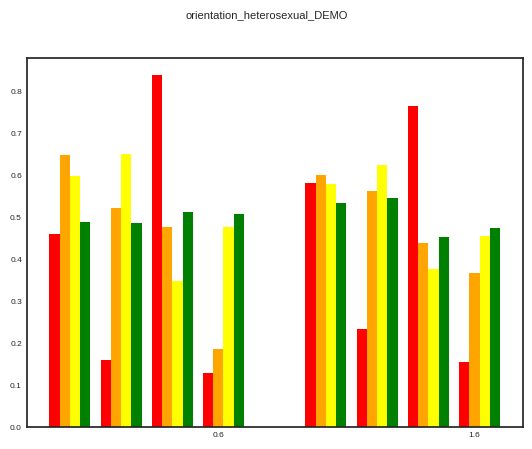

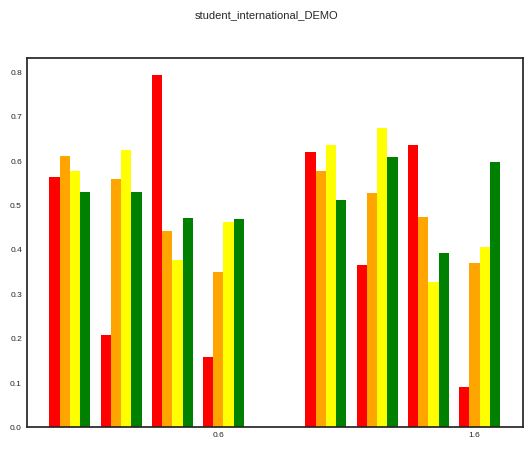

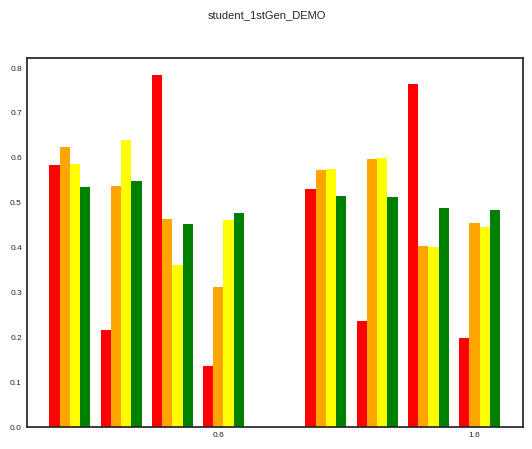

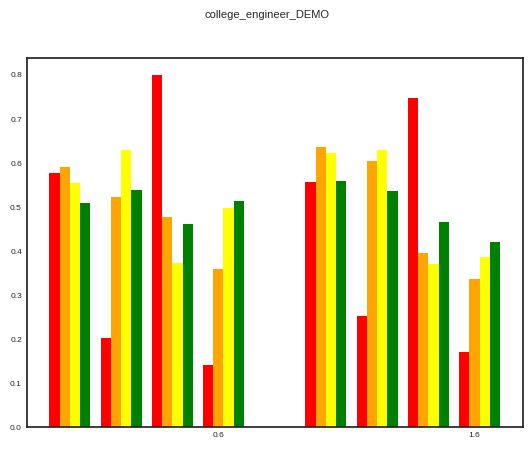

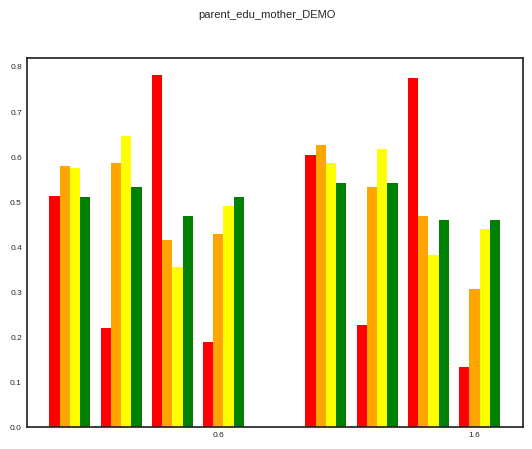

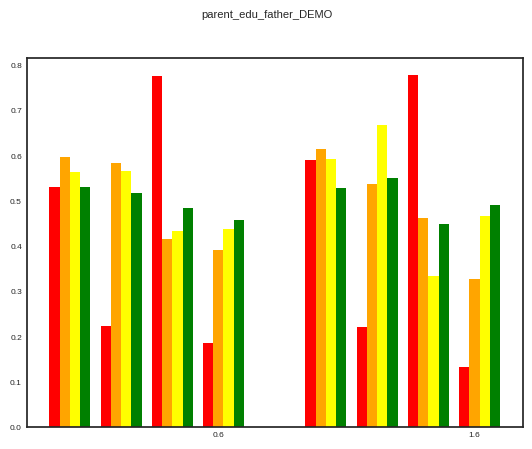

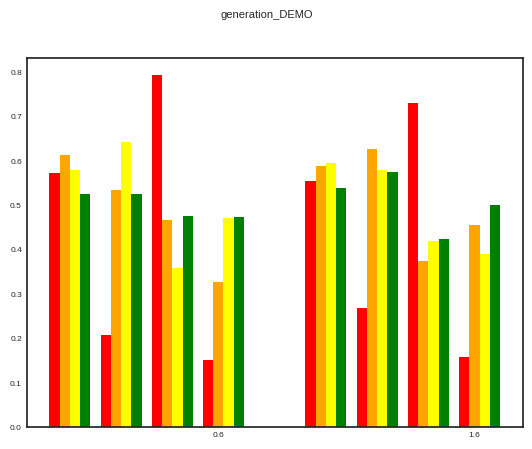

In [112]:
config_names = ['ml_wang', 'ml_xu_interpretable', 'ml_xu_personalized']
eval_task = 'single'
pred_target = 'dep_weekly'
ds_keys = ['INS-W_1', 'INS-W_2', 'INS-W_3', 'INS-W_4']

ds_keys, config_names = ['INS-W_1'], ['ml_wang', 'ml_chikersal', 'ml_xu_interpretable', 'ml_xu_personalized']

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']

for k, ds_key in enumerate(ds_keys):
    n_cfg = len(config_names)
    axes = {}
    for i, config_name in enumerate(config_names):
        folder = os.path.join('./tmp/cross_validate/', config_name, eval_task, pred_target, ds_key)
        dirs = os.listdir(folder)
        prefices = set([dir[:-7] for dir in dirs])
        cnt = len(dirs) // len(prefices)
        preds = []
        targs = []
        demos = []
        for j in range(cnt):
            path_pred = os.path.join(folder, 'y_pred_{:03d}.npy'.format(j + 1))
            path_targ = os.path.join(folder, 'y_targ_{:03d}.csv'.format(j + 1))
            path_demo = os.path.join(folder, 'demographic_test_{:03d}.csv'.format(j + 1))

            pred = np.load(path_pred, allow_pickle=True)
            targ = pd.read_csv(path_targ)["y_raw"]
            demo = pd.read_csv(path_demo).iloc[:, 1:]

            preds.append(pred)
            targs.append(targ)
            demos.append(demo)

        pred = np.concatenate(preds)
        targ = pd.concat(targs)
        demo = pd.concat(demos)

        metrics = {"accuracy": accuracy_score, "recall": recall_score, "fnr": false_negative_rate, "fpr": false_positive_rate}


        mfs = {}
        for l, col in enumerate(demo.columns):
            mf = MetricFrame(metrics=metrics, y_true=targ, y_pred=pred, sensitive_features=demo[col])
            mfs[col] = (mf)

            xs = []
            ticks = []

            if not i:
                plt.figure(l)
                plt.suptitle(col)
                axes[col] = plt.subplot(1, 1, 1)
                for j, met in enumerate(metrics):
                    axes[col].set_xticks(np.arange(len(mf.by_group[met].values)))
                    if col == 'gender_DEMO':
                        axes[col].set_xticks(np.arange(len(mf.by_group[met].values)), ['Male', 'Non-male'])
                    if col == 'race_DEMO':
                        axes[col].set_xticks(np.arange(len(mf.by_group[met].values)), ["Asian", "White", 'Biracial', 'Black', 'Latinx'])
            n_met = len(metrics)
            for j, met in enumerate(metrics):
                y = mf.by_group[met].values
                width = .8 / ((n_cfg + 1) * n_met)
                x = np.arange(y.shape[0]) - y.shape[0] / 2 * width + i * width + j * width * (n_cfg + 1)
                axes[col].bar(x, y, width = width, label = config_name, color = colors[i])

            

        folder_output = os.path.join('./tmp/cross_validate_output/', config_name, eval_task, pred_target, ds_key)
        mkdir(os.path.join(folder_output))
        for col, mf in mfs.items():
            mf.by_group.to_csv(os.path.join(folder_output, '{}_by_group.csv'.format(col)))
            mf.overall.to_csv(os.path.join(folder_output, '{}_overall.csv'.format(col)))
    
    plt.show()